<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-Ice" data-toc-modified-id="Read-Ice-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read Ice</a></span><ul class="toc-item"><li><span><a href="#BP12-timeseries" data-toc-modified-id="BP12-timeseries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>BP12 timeseries</a></span></li><li><span><a href="#OBC-NSIDC-timeseries" data-toc-modified-id="OBC-NSIDC-timeseries-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>OBC NSIDC timeseries</a></span></li></ul></li><li><span><a href="#Calc-difference-between-model-and-observation" data-toc-modified-id="Calc-difference-between-model-and-observation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calc difference between model and observation</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span></li></ul></div>

# Supplementary: Plot sea ice


Plot sea ice seasonal cycle from the BIOPERIANT12 vs NSIDC monthly means

**Analysis Source :**  
Marcel du Plessis, Alice D. Lebehot

In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
import bp12_tools as bp12
import bp12_tools.plot_utils as pu

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy import crs as ccrs, feature as cfeature
from cmcrameri import cm
import cmocean as cmo

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

---

## Read Ice

### BP12 timeseries

In [2]:
df_m = xr.open_dataset(f"../data/ICE/BIOPERIANT12_timeseries_sie_IA_monthly.nc")

In [3]:
dfm_mean = df_m.sie.groupby(df_m['time'].dt.month).mean()
dfm_std = df_m.sie.groupby(df_m['time'].dt.month).std()

### OBC NSIDC timeseries

In [4]:
df_o = xr.open_dataset(f"../data/ICE/OBS_sie_IA_monthly.nc")

Make OBS climatology

In [5]:
dfo_mean = df_o.sie.groupby(df_o['time'].dt.month).mean()
dfo_std = df_o.sie.groupby(df_o['time'].dt.month).std()

**Rearrange climatology to start in July**

In [6]:
obs_mean = np.concatenate((dfo_mean[6:], dfo_mean[:6]))
mdl_mean = np.concatenate((dfm_mean[6:], dfm_mean[:6]))
obs_std  = np.concatenate((dfo_std[6:], dfo_std[:6]))
mdl_std  = np.concatenate((dfm_std[6:], dfm_std[:6]))

## Calc difference between model and observation

In [7]:
diffMean = mdl_mean - obs_mean

# Grow melt: difference between one month with the previous on
diffMeanObs = np.insert(np.diff(obs_mean), 0, obs_mean[0] - obs_mean[-1])

 # First value doesn't have a difference, so we define one using the last data 

diffMeanModel = np.insert(np.diff(mdl_mean), 0, mdl_mean[0] - mdl_mean[-1])

## Plot

In [8]:
red = pu.formatting.get_rbg_colors('r')
blue = pu.formatting.get_rbg_colors('b')

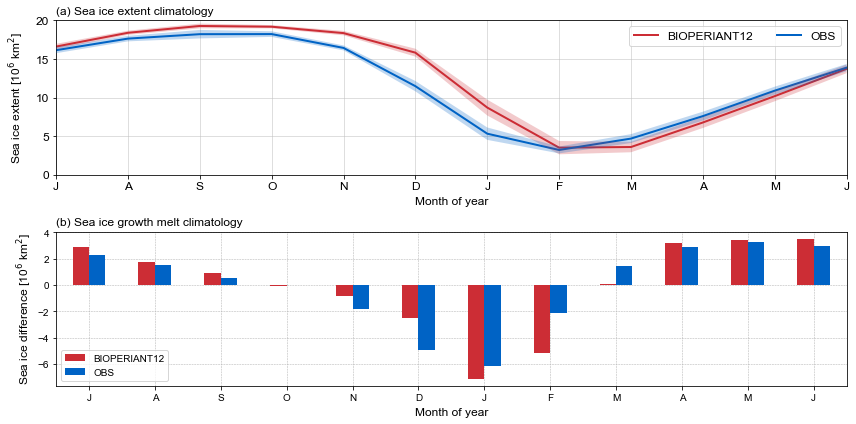

In [10]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(211)
# --------------- PLOT MODEL --------------- #
ax.plot(np.arange(12) ,mdl_mean , c=red, lw=2, label='BIOPERIANT12')
ax.fill_between(np.arange(12), mdl_mean+mdl_std, mdl_mean-mdl_std, alpha=0.25, zorder=20, facecolor=red)
# --------------- PLOT OBSERVATIONS --------------- #
ax.plot(np.arange(12), obs_mean, c=blue, lw=2, label='OBS')
ax.fill_between(np.arange(12), obs_mean+obs_std, obs_mean-obs_std, alpha=0.25, zorder=20, facecolor=blue)

ax.set_xlim(0, 11)
ax.xaxis.set_ticks(np.arange(12))
ax.xaxis.set_ticklabels(['J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J'])
ax.set_xlabel('Month of year', labelpad=5, fontsize=12)

ax.grid(zorder=1, lw=1, ls='-', c='0.75', alpha=0.5)
ax.legend(loc=1, ncol=2, fontsize=12)

ax.set_ylabel('Sea ice extent [10$^6$ km$^2$]', labelpad=10, fontsize=12)
ax.set_ylim(0, 20)
ax.tick_params(labelsize=12)
ax.set_title('(a) Sea ice extent climatology', loc='left', fontsize=12)
ax.set_rasterized(True)


ax2 = fig.add_subplot(212)

frames = [diffMeanModel, diffMeanObs]

dfClimExtentDiff = pd.DataFrame(np.array(frames).T, 
                            columns=['BIOPERIANT12', 'OBS'], 
                            index=dfo_mean.month)
dfClimExtentDiff.plot.bar(ax=ax2, zorder=30, color=[red, blue]);
ax2.grid(ls='--', lw=0.5)
ax2.xaxis.set_ticklabels(['J', 'A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J'], rotation=0)
ax2.set_xlabel('Month of year', labelpad=5, fontsize=12)

ax2.set_ylabel('Sea ice difference [10$^6$ km$^2$]', fontsize=12)
ax2.set_title('(b) Sea ice growth melt climatology', loc='left', fontsize=12)
ax2.set_rasterized(True)
plt.tight_layout()
plt.savefig(f'../figures/S08.png', bbox_inches='tight')